In [14]:
import csv
import numpy as np
import scipy as sp
import pandas as pd
import math 
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing
# and implement 90-10 splitting as specified in the project description.
def preprocess(filename):

    data = pd.read_csv(filename)

    train_data, test_data = train_test_split(data, test_size = 0.10, shuffle = False)

    return train_data, test_data

In [16]:
def lessthan(df_lessthan, numeric_att):
        numeric = {}
        nominal = {}
        
        for cols in df_lessthan.columns[0:-1]:
            if cols not in numeric_att:
                likelihood = (df_lessthan.groupby(cols).size())/len(df_lessthan)
                nominal[cols] = likelihood
            else:
                mean = df_lessthan[cols].mean()
                sd = df_lessthan[cols].std()
                numeric[cols] = ([mean, sd])
                
        return numeric, nominal
            

In [17]:
def morethan(df_morethan, numeric_att):
        numeric = {}
        nominal = {}
        
        for cols in df_morethan.columns[0:-1]:
            if cols not in numeric_att:
                likelihood = (df_morethan.groupby(cols).size())/len(df_morethan)
                nominal[cols] = likelihood
            else:
                mean = df_morethan[cols].mean()
                sd = df_morethan[cols].std()
                numeric[cols] = ([mean, sd])
           
        return numeric, nominal

In [18]:
# This function should calculat prior probabilities and likelihoods (conditional probabilities) from the training data and using
# to build a naive Bayes model

def train(train_data, test_data):    
    
    prior = {}
    
    posterior_lessthan_nom = {}
    posterior_greaterthan_nom = {}
    posterior_lessthan_num = {}
    posterior_greaterthan_num = {}
    
    
    file = pd.read_csv(filename)
    
    y_actual = test_data['label']
    test_data = test_data.iloc[:,:-1]
   
   
    prior_prob = (train_data.groupby('label').size())/len(train_data)
    
    prior[' <=50K'] = prior_prob[0]
    prior[' >50K'] = prior_prob[1]
    
    
    df_lessthan = train_data.loc[train_data['label'] == ' <=50K']
    df_morethan = train_data.loc[train_data['label'] == ' >50K']

    
    numeric_att = ['age', 'education num', 'hours per week']
   
    #calculting the probabilities of numerical and nominal variables
    posterior_lessthan_num, posterior_lessthan_nom = lessthan(df_lessthan, numeric_att)
    posterior_greaterthan_num, posterior_greaterthan_nom = morethan(df_morethan, numeric_att)
    
    return df_lessthan, df_morethan, y_actual, test_data, prior_prob, posterior_lessthan_nom, posterior_greaterthan_nom, posterior_lessthan_num, posterior_greaterthan_num
    

In [19]:
def gaussian_prob(value, mean, sd):
    
    denom = 1/(sd*math.sqrt(2*math.pi))
    num = math.exp((-1/2)*(((value - mean)/sd)**2))

    gaussian = denom * num
    
    return gaussian

In [20]:
# This function should predict classes for new items in the testing data
def predict(y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num):
    
    
    numeric_att = ['age', 'education num', 'hours per week']
    nominal_att = [att for att in test_data.columns if att not in numeric_att]
    
    y_pred = []
    
     
    total_lessthan = 0
    total_morethan = 0
    
   
    
        
    for i in test_data.index:
        for col in numeric_att:
            total_lessthan += math.log(gaussian_prob(test_data[col][i], lessthan_num[col][0], lessthan_num[col][1]))
            total_morethan += math.log(gaussian_prob(test_data[col][i], greaterthan_num[col][0], greaterthan_num[col][1]))

                
        for cols in nominal_att:

            val_1 = lessthan_nom[cols]
            
            if np.finfo('float64').eps < (1/len(df_lessthan)):
                epsilon_less = np.finfo('float64').eps
            else:
                epsilon_less = 0
                
            if test_data[cols][i] in (df_lessthan.groupby([cols]).size()).index:
                vals_1 = val_1[test_data[cols][i]]
                total_lessthan += math.log(vals_1)
            else:
                #prob_less = np.finfo('float64').eps
                total_lessthan += math.log(epsilon_less)
                
                
            if np.finfo('float64').eps < (1/len(df_morethan)):
                epsilon_more = np.finfo('float64').eps
            else:
                epsilon_more = 0

            val_2 = greaterthan_nom[cols]

            if test_data[cols][i] in (df_morethan.groupby([cols]).size()).index:
                vals_2 = val_2[test_data[cols][i]]
                total_morethan += math.log(vals_2)
            else:
                #prob_more = np.finfo('float64').eps
                total_morethan += math.log(epsilon_more)

        final_lessthan = math.log(prior_prob[0]) + total_lessthan
        final_morethan = math.log(prior_prob[1]) + total_morethan

        y_pred.append([final_lessthan, final_morethan])


        total_lessthan = 0
        total_morethan = 0
    
 
    predicted_class = []
    
    for row in y_pred:
        if row[0]<row[1]:
            predicted_class.append('>50K')
        elif row[0]>row[1]:
            predicted_class.append('<=50K')
    return y_pred, predicted_class, y_actual

In [116]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels, return and output accuracy, confusion matrix and F1 score.

def evaluate(y_hat, clas, y_actual):

    y = [rows for rows in y_actual]

    labels = [' <=50K', ' >50K']
    labels_2 = ['<=50K', '>50K']
 
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(clas)): 
    
        if ((clas[i])==(labels_2[0]) and (y[i]==labels[0])):
            TP += 1
        if ((clas[i])==(labels_2[1]) and (y[i]==labels[1])):
            TN += 1
        if ((y[i])==(labels[1]) and (clas[i]==labels_2[0])):
            FP += 1
        if (((y[i])==(labels[0]) and (clas[i]==labels_2[1]))):
            FN += 1
    
    
    accuracy = (TP+TN)/len(y_hat)
    precision = TP/(TP+FP)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    F1score = (2*precision*sensitivity)/(sensitivity + precision)
    
    
    confusion_matrix = ([[TP, FN], [FP, TN]])
 
    return confusion_matrix, accuracy, F1score

In [115]:

# This cell should act as your "main" function where you call the above functions 
# on the full ADULT data set, and print the evaluation results. [0.33 marks]


# First, read in the data and apply your NB model to the ADULT data
filename = 'adult.csv'

train_data, test_data = preprocess(filename)

df_lessthan, df_morethan, y_actual, test_data, prior_prob, posterior_lessthan_nom, posterior_greaterthan_nom, posterior_lessthan_num, posterior_greaterthan_num = train(train_data, test_data)

y_pred, predicted_class, y_actual = predict(y_actual, test_data, prior_prob, posterior_lessthan_nom, posterior_greaterthan_nom, posterior_lessthan_num, posterior_greaterthan_num)
# Second, print the full evaluation results from the evaluate() function

confusion_matrix, accuracy, F1score = evaluate(y_pred, predicted_class, y_actual)

print('Accuracy: ', accuracy)
print('\n')
print('Confusion Matrix:\n')
c = (['Positive',confusion_matrix[0][0], confusion_matrix[1][0]], ['Negative',confusion_matrix[0][1], confusion_matrix[1][1]])
matrix = pd.DataFrame(c, columns = [' ', 'Positive', 'Negative'], index = None)
print(matrix.to_string(index=False))
print('\n')
print('F1score: ', F1score)
print('\n')


# Third, print data statistics and model predictions, as instructed below 
# N is the total number of instances, F the total number of attributes, L the total number of labels
# The "class probabilities" may be unnormalized
# The "predicted class ID" must be in range (0, L)

print("Attribute vectors of instances [0, 1, 2]: ", train_data.loc[[0]].to_numpy(), train_data.loc[[1]].to_numpy(), train_data.loc[[2]].to_numpy()) # of the first three records in adult.csv

print("\nNumber of instances (N): ", len(test_data) +len(train_data) )
print("Number of attributes (F): ", len(test_data.columns) )
print("Number of labels (L): ", len(set(predicted_class)))


# print out the prediction results of the last three instances
print("\n\nPredicted class log-probabilities for instance N-3: ", y_pred[len(y_pred)-3])
print("Predicted class ID for instance N-3: ", predicted_class[len(predicted_class)-3] )
print("\nPredicted class log-probabilities for instance N-2: ", y_pred[len(y_pred)-2])
print("Predicted class ID for instance N-2: ",predicted_class[len(predicted_class)-2] )
print("\nPredicted class log-probabilities for instance N-1: ", y_pred[len(y_pred)-1])
print("Predicted class ID for instance N-1: ", predicted_class[len(predicted_class)-1])



Accuracy:  0.86


Confusion Matrix:

          Positive  Negative
Positive        69         6
Negative         8        17


F1score:  0.9078947368421053


Attribute vectors of instances [0, 1, 2]:  [[68 ' ?' ' 1st-4th' 2 ' Divorced' ' ?' ' Not-in-family' ' White'
  ' Female' 20 ' United-States' ' <=50K']] [[39 ' State-gov' ' Bachelors' 13 ' Never-married' ' Adm-clerical'
  ' Not-in-family' ' White' ' Male' 40 ' United-States' ' <=50K']] [[50 ' Self-emp-not-inc' ' Bachelors' 13 ' Married-civ-spouse'
  ' Exec-managerial' ' Husband' ' White' ' Male' 13 ' United-States'
  ' <=50K']]

Number of instances (N):  1000
Number of attributes (F):  11
Number of labels (L):  2


Predicted class log-probabilities for instance N-3:  [-20.71689698193305, -19.556273652832147]
Predicted class ID for instance N-3:  >50K

Predicted class log-probabilities for instance N-2:  [-25.33907063773019, -22.744589775643146]
Predicted class ID for instance N-2:  >50K

Predicted class log-probabilities for instanc

In [39]:
#Calculting sensitivity and specificity

TP = confusion_matrix[0][0]
FN = confusion_matrix[0][1]
FP = confusion_matrix[1][0]
TN = confusion_matrix[1][1]

sensitivity = TP/(TP+FN)
specificity = TN/(TN+FP)

print('Sensitivity: ', sensitivity)
print('Specificity: ', specificity)

Sensitivity:  0.8961038961038961
Specificity:  0.7391304347826086



### Model details:

 * The orginal dataset was split into training and testing sets (90 -10) split.
 * Gaussian distribution was used for the conditional probabilities of numeric values.
 * Strictly positive and very small constant - epsilon is used for the test values which have a conditional probability of zero. 
 
 
The evaluated model is 90% sensitive and 74% specific. The higher value of sensitivity suggests that this model is better at predicting true positive cases than predicting true nagative cases. There is approximately 16% difference between the two in this model. The training dataset has 900 values split according to the class labels as shown below - 
 
```        
          Total count
label        
 <=50K    692
 >50K     208
 ```
The above table shows that only 30% of the training values belong to the negative class label showing a bias towards the positive class. This suggests that the lower specificity is caused by the lower amount of negative class values in the training dataset (i.e. the model is learning a smaller number of negative class instances and hence is not able to classify all the negative values in the test dataset). 

The model performance can be improved by - 
   * Changing the train-test split to 70-30 or a ratio which gives more training values since the current dataset       is quite small for a 90-10 split
   * Using a more balanced dataset
   * Removing the correlated features
   * Handling text-data by applying cleaning techniques such as stemming, lemmatization
 

In [107]:
#Question 2 part a

def KDE_gaussian(testvalue, df, col, kernel_bandwidth):
    
    total = 0
    
    for value in df[col]:
        total += gaussian_prob(testvalue, value, kernel_bandwidth)
   
    return ((1/len(df))*total)

In [108]:
def predict_with_KDE(df_lessthan, df_morethan, sigma, y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num):
    
    
    numeric_att = ['age', 'education num', 'hours per week']
    nominal_att = [att for att in test_data.columns if att not in numeric_att]
    
    
    y_pred = []
    
     
    total_lessthan = 0
    total_morethan = 0
    
  

    for i in test_data.index:
        
        for col in numeric_att:
            
            total_lessthan += math.log(KDE_gaussian(test_data[col][i], df_lessthan, col, sigma))
            total_morethan += math.log(KDE_gaussian(test_data[col][i], df_morethan, col, sigma))
        
        for cols in nominal_att:

            val_1 = lessthan_nom[cols]
            
            if np.finfo('float64').eps < (1/len(df_lessthan)):
                epsilon_less = np.finfo('float64').eps
            else:
                epsilon_less = 0
                
            if test_data[cols][i] in (df_lessthan.groupby([cols]).size()).index:
                vals_1 = val_1[test_data[cols][i]]
                total_lessthan += math.log(vals_1)
            else:
                #prob_less = np.finfo('float64').eps
                total_lessthan += math.log(epsilon_less)
                
                
            if np.finfo('float64').eps < (1/len(df_morethan)):
                epsilon_more = np.finfo('float64').eps
            else:
                epsilon_more = 0

            val_2 = greaterthan_nom[cols]

            if test_data[cols][i] in (df_morethan.groupby([cols]).size()).index:
                vals_2 = val_2[test_data[cols][i]]
                total_morethan += math.log(vals_2)
            else:
                #prob_more = np.finfo('float64').eps
                total_morethan += math.log(epsilon_more)

        final_lessthan = math.log(prior_prob[0]) + total_lessthan
        final_morethan = math.log(prior_prob[1]) + total_morethan

        y_pred.append([final_lessthan, final_morethan])


        total_lessthan = 0
        total_morethan = 0
 
    predicted_class = []
    for row in y_pred:
        if row[0]<row[1]:
            predicted_class.append('>50K')
        elif row[0]>row[1]:
            predicted_class.append('<=50K')
    return y_pred, predicted_class, y_actual

In [110]:
def bandwidth_selection(df_lessthan, df_morethan, y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num):
    

    bandwidth = [3,5,7,9,15]
    max_accuracy = {}
    maxval = 0
    band = 0
    for val in bandwidth:
        y_pred, predicted_class, y_actual = predict_with_KDE(df_lessthan, df_morethan, val, y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num)
        confusion_matrix, accuracy, F1score = evaluate(y_pred, predicted_class, y_actual)
        max_accuracy[str(accuracy)] = [F1score, confusion_matrix]
        if maxval == 0:
            maxval = accuracy
            band = val
        elif accuracy > maxval:
            maxval = accuracy
            band = val
            
        print(f" Bandwidth: {val}, Accuracy: {accuracy}, F1score: {F1score}")
        
    print(f" KDE bandwidth: {band}, Max Accuracy: {maxval}, F1score: {max_accuracy[str(maxval)][0]}")
    #return sort(max_accuracy[0])
        

In [111]:
filename = 'adult.csv'

train_data, test_data = preprocess(filename)

df_lessthan, df_greaterthan, y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num = train(train_data, test_data)

bandwidth_selection(df_lessthan, df_greaterthan, y_actual, test_data, prior_prob, lessthan_nom, greaterthan_nom, lessthan_num, greaterthan_num)


#print(f" Mean for less than: {lessthan_num}, SD: {lessthan_num}, '\n', Mean for greater than: {greaterthan_num}, SD: {greaterthan_num}")

 Bandwidth: 3, Accuracy: 0.86, F1score: 0.9066666666666665
 Bandwidth: 5, Accuracy: 0.81, F1score: 0.8689655172413794
 Bandwidth: 7, Accuracy: 0.82, F1score: 0.8767123287671235
 Bandwidth: 9, Accuracy: 0.83, F1score: 0.8827586206896552
 Bandwidth: 15, Accuracy: 0.83, F1score: 0.8827586206896552
 KDE bandwidth: 3, Max Accuracy: 0.86, F1score: 0.9066666666666665




For the current model - 

 * Accuracy without KDE = 86%
 * Accuracy with KDE = 86%

The current dataset (adult.csv) contains 3 numerical variables and 8 categorical variables. Looking at the plots of these columns - 


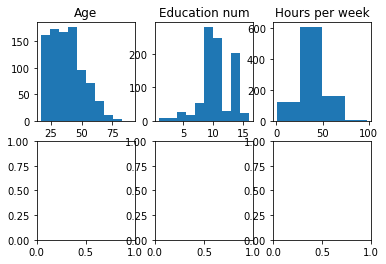

In [98]:
train_data, test_data = preprocess('adult.csv')
  
figure, axis = plt.subplots(2, 3)
  
axis[0, 0].hist(train_data['age'])
axis[0, 0].set_title("Age")

axis[0, 1].hist(train_data['education num'])
axis[0, 1].set_title("Education num")
  
axis[0, 2].hist(train_data['hours per week'], bins=4)
axis[0, 2].set_title("Hours per week")

plt.savefig('Train data.png')

This shows that the numerical columns in the training dataset do not follow a normal distribution except 'Hours of week' which is closer to a Gaussian distribution. But as the number of numerical attributes is only 3 compared to the 8 nominal attributes, this impact is not significant as the log of the probabilities lie between 0-1.

For without KDE evalutation, the model loops through a few values for the selection of the kernel bandwidth. In the end the kernel bandwidth with the highest accuracy has been selected. Again just as the Gaussian model,the model takes log of the probabilities; the smaller number of numerical attributes compared to the much larger number of nominal attributes do not impact significantly on the model evaluation resulting into similar accuracies for the with and without KDE evaluations. 

Hence both the methods are suitable for the model as they are resulting in the same accuracies. 

In [120]:
#Question 2 part b

filename = 'adult.csv'

data = pd.read_csv(filename)
#print(data)
dat1 = np.array(data)
#print(dat1)

total_accuracy = 0
total_recall = 0
total_sensitivity = 0
total_specificity = 0

folds = [2, 10]

for fold in folds:
    
    kfold = KFold(n_splits = fold, random_state=None, shuffle=False)

    for trainset, test in kfold.split(data):

        train_data = pd.DataFrame(dat1[trainset], columns = [cols for cols in data.columns])
        test_data = pd.DataFrame(dat1[test], columns = [cols for cols in data.columns])
        #print('train: %s, test: %s' % (train_data, test_data))
        #print(test_data.dtypes)

        df_lessthan, df_morethan, y_actual, test_data, prior_prob, posterior_lessthan_nom, posterior_greaterthan_nom, posterior_lessthan_num, posterior_greaterthan_num = train(train_data, test_data)

        y_pred, predicted_class, y_actual = predict(y_actual, test_data, prior_prob, posterior_lessthan_nom, posterior_greaterthan_nom, posterior_lessthan_num, posterior_greaterthan_num)


        confusion_matrix, accuracy, F1score = evaluate(y_pred, predicted_class, y_actual)

        total_recall += confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1])
        total_accuracy += accuracy
        total_sensitivity += confusion_matrix[0][0]/(confusion_matrix[0][0] + confusion_matrix[0][1])
        total_specificity += confusion_matrix[1][1]/(confusion_matrix[1][1]+confusion_matrix[1][0])
        
    print('k-folds = ', fold)
    print('Average accuracy = ', total_accuracy/fold)
    print('Average recall = ', total_recall/fold)
    print('Average senstivity = ', total_sensitivity/fold)
    print('Average Specificity = ', total_specificity/fold)
    print('\n')
    
    total_accuracy = 0
    total_recall = 0
    total_sensitivity = 0
    total_specificity = 0
    

k-folds =  2
Average accuracy =  0.817
Average recall =  0.8518507244612201
Average senstivity =  0.8518507244612201
Average Specificity =  0.7027523623818809


k-folds =  10
Average accuracy =  0.8119999999999999
Average recall =  0.8422969053304696
Average senstivity =  0.8422969053304696
Average Specificity =  0.7127698935525022






Following are the results from the cross-validations - 
 * 2-fold: Accuracy = 82%, Recall = 85%, Specificity = 70%
 * 10-fold: Accuracy = 81%, Recall = 84%, Specificity = 71%
 
Looking at these metrics, it can be seen that the 2-fold model performs better in predicting the true positive cases whereas the 10-fold performs slightly better at prediciting the true negative cases. 

Overall, both the models perform similarly starting that for this dataset the size of the m-fold is sufficient at both m=2 and m=10 suggesting that both type of folds are providing enough data for the model to train and test. 

 